# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.0 MB/s eta 0:00:00


Импорт необходимых библиотек

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [11]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [13]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [14]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [16]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [17]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели

In [18]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [30]:
def train(model, optimizer, criterion, train_dataloader, eval_dataloader, n_epochs):
    model.to(device)
    losses = []
    accuracy = []
    for epoch in range(n_epochs):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Training epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(batch["input_ids"])
            loss = criterion(logits, batch["label"])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))

        predictions = []
        targets = []
        model.eval()
        with torch.no_grad():
            for batch in eval_dataloader:
                logits = model(batch["input_ids"])
                predictions.append(torch.argmax(logits, dim=1))
                targets.append(batch["label"])

        predictions = torch.cat(predictions)
        targets = torch.cat(targets)
        accuracy.append((predictions == targets).float().mean().item())

        print(f"loss: {losses[-1]}, accuracy: {accuracy[-1]}")

    return losses, accuracy

Сначала обучим базовую модель с типом агрегации max

In [31]:
model_base_max = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type="max")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_base_max.parameters())

In [32]:
losses_base_max, accuracy_base_max = train(model_base_max, optimizer,
                                           criterion, train_dataloader,
                                           eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.40340884063194193, accuracy: 0.8871999979019165


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.27779624017079674, accuracy: 0.88919997215271


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.245762019114693, accuracy: 0.9001999497413635


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.22563849003414313, accuracy: 0.9039999842643738


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20707808878719808, accuracy: 0.9043999910354614


In [34]:
print(f"Accuracy of model_base_max: {evaluate(model_base_max, eval_dataloader)}")

Accuracy of model_base_max: 0.9043999910354614


Обучим базовую модель с типом агрегации mean

In [35]:
model_base_mean = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type="mean")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_base_mean.parameters())

In [36]:
losses_base_mean, accuracy_base_mean = train(model_base_mean, optimizer,
                                             criterion, train_dataloader,
                                             eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.43730876093904175, accuracy: 0.8930000066757202


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2580286936963598, accuracy: 0.9037999510765076


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.21285449554075797, accuracy: 0.9025999903678894


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1842003299754113, accuracy: 0.9106000065803528


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.16063008874952794, accuracy: 0.8980000019073486


In [37]:
print(f"Accuracy of model_base_mean: {evaluate(model_base_mean, eval_dataloader)}")

Accuracy of model_base_mean: 0.8980000019073486


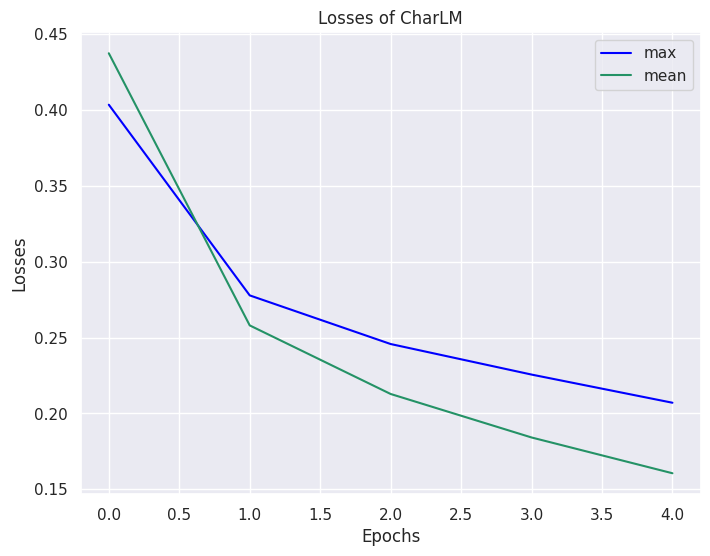

In [49]:
plt.figure(figsize=(8,6))
plt.plot(losses_base_max, label="max", c="blue")
plt.plot(losses_base_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

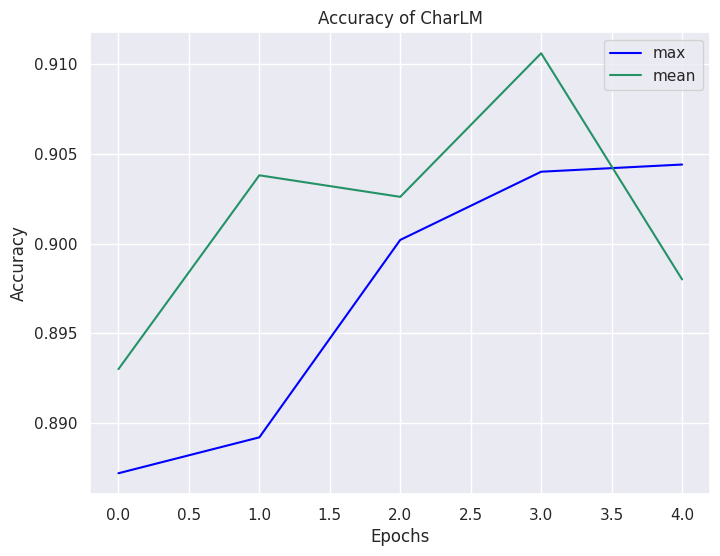

In [51]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_base_max, label="max", c="blue")
plt.plot(accuracy_base_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

### Первый эксперимент

Попробуем увеличить количество рекуррентных слоев

In [52]:
class CharLM_Layers(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max', rnn_layers: int = 1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rnn_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

2 RNN слоя

In [55]:
model_rnn2_max = CharLM_Layers(hidden_dim=256, vocab_size=len(vocab),
                               aggregation_type="max", rnn_layers=2)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_rnn2_max.parameters())

In [56]:
losses_rnn2_max, accuracy_rnn2_max = train(model_rnn2_max, optimizer,
                                           criterion, train_dataloader,
                                           eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.41598653371532757, accuracy: 0.8873999714851379


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.26867619041775664, accuracy: 0.8953999876976013


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.23231566558380923, accuracy: 0.8935999870300293


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20662153128360708, accuracy: 0.9081999659538269


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.18998800422300896, accuracy: 0.9081999659538269


In [57]:
print(f"Accuracy of model_rnn2_max: {evaluate(model_rnn2_max, eval_dataloader)}")

Accuracy of model_rnn2_max: 0.9081999659538269


In [58]:
model_rnn2_mean = CharLM_Layers(hidden_dim=256, vocab_size=len(vocab),
                                aggregation_type="mean", rnn_layers=2)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_rnn2_mean.parameters())

In [59]:
losses_rnn2_mean, accuracy_rnn2_mean = train(model_rnn2_mean, optimizer,
                                             criterion, train_dataloader,
                                             eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4388794255187114, accuracy: 0.8819999694824219


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.26550519432971875, accuracy: 0.901199996471405


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.21963496226295828, accuracy: 0.8980000019073486


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.18933290083507698, accuracy: 0.897599995136261


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.16674736182689667, accuracy: 0.9035999774932861


In [60]:
print(f"Accuracy of model_rnn2_mean: {evaluate(model_rnn2_mean, eval_dataloader)}")

Accuracy of model_rnn2_mean: 0.9035999774932861


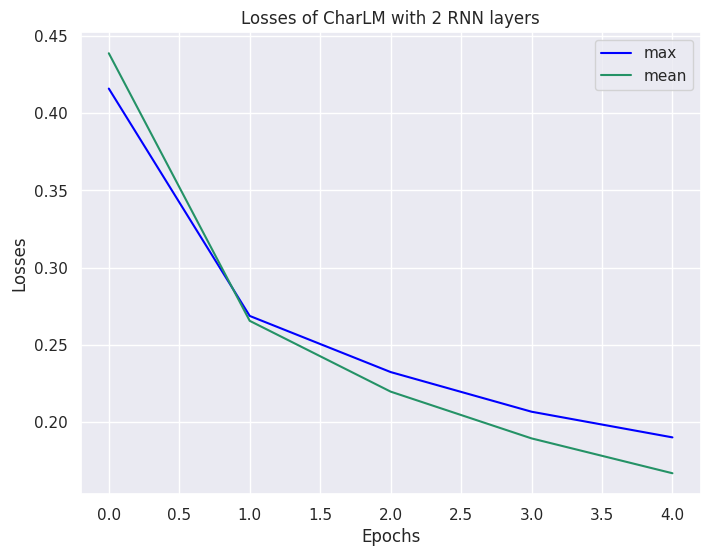

In [61]:
plt.figure(figsize=(8,6))
plt.plot(losses_rnn2_max, label="max", c="blue")
plt.plot(losses_rnn2_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM with 2 RNN layers")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

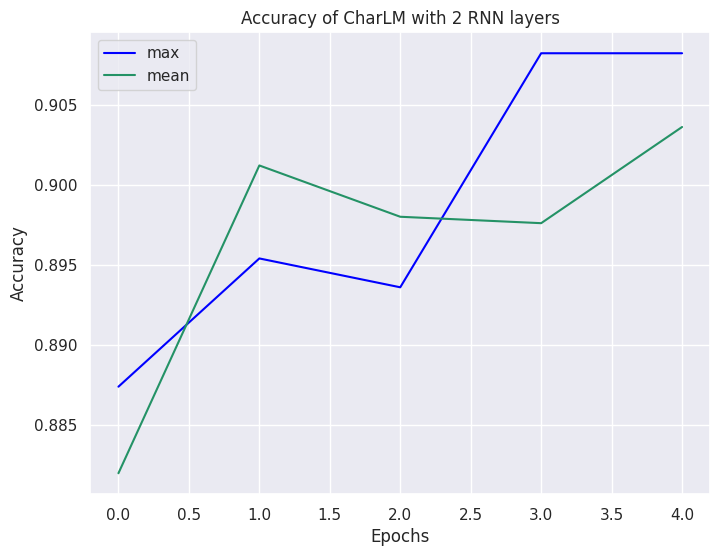

In [62]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_rnn2_max, label="max", c="blue")
plt.plot(accuracy_rnn2_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM with 2 RNN layers")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

3 RNN слоя

In [63]:
model_rnn3_max = CharLM_Layers(hidden_dim=256, vocab_size=len(vocab),
                               aggregation_type="max", rnn_layers=3)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_rnn3_max.parameters())

In [64]:
losses_rnn3_max, accuracy_rnn3_max = train(model_rnn3_max, optimizer,
                                           criterion, train_dataloader,
                                           eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.5093326279759407, accuracy: 0.8885999917984009


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3089892725110054, accuracy: 0.8959999680519104


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2685900762716929, accuracy: 0.8925999999046326


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2452839392274618, accuracy: 0.9073999524116516


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2289887376241386, accuracy: 0.8853999972343445


In [65]:
print(f"Accuracy of model_rnn3_max: {evaluate(model_rnn3_max, eval_dataloader)}")

Accuracy of model_rnn3_max: 0.8853999972343445


In [66]:
model_rnn3_mean = CharLM_Layers(hidden_dim=256, vocab_size=len(vocab),
                                aggregation_type="mean", rnn_layers=3)

criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_rnn3_mean.parameters())

In [67]:
losses_rnn3_mean, accuracy_rnn3_mean = train(model_rnn3_mean, optimizer,
                                             criterion, train_dataloader,
                                             eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4806530164152384, accuracy: 0.8799999952316284


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.28782921249866483, accuracy: 0.8937999606132507


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.24571692802806697, accuracy: 0.9049999713897705


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2199731284111738, accuracy: 0.9009999632835388


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20049226579939325, accuracy: 0.9013999700546265


In [68]:
print(f"Accuracy of model_rnn3_mean: {evaluate(model_rnn3_mean, eval_dataloader)}")

Accuracy of model_rnn3_mean: 0.9013999700546265


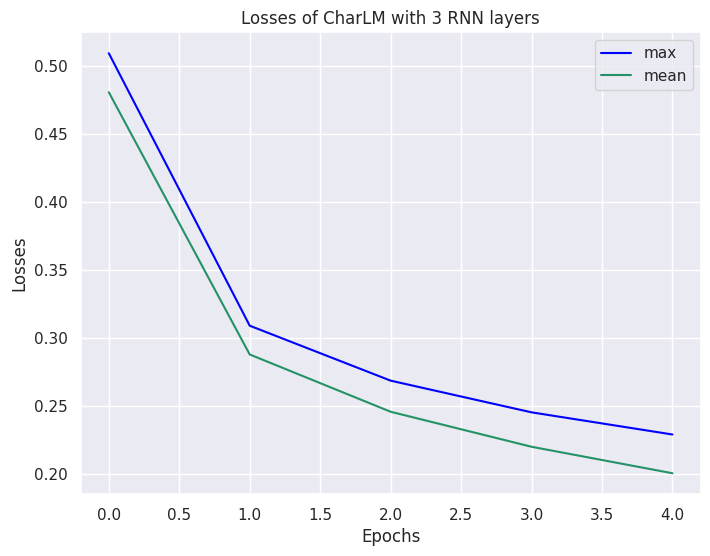

In [69]:
plt.figure(figsize=(8,6))
plt.plot(losses_rnn3_max, label="max", c="blue")
plt.plot(losses_rnn3_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM with 3 RNN layers")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

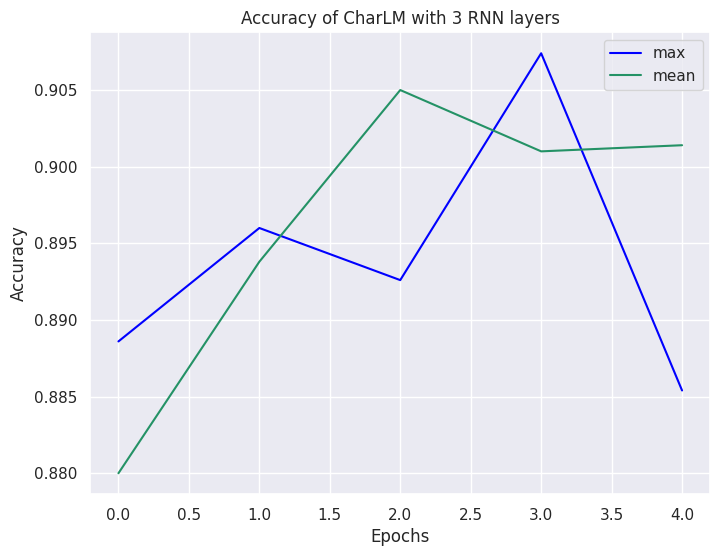

In [70]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_rnn3_max, label="max", c="blue")
plt.plot(accuracy_rnn3_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM with 3 RNN layers")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

### Второй эксперимент

Попробуем использовать другую архитектуру вместо Vanilla RNN

GRU

In [71]:
class CharLM_GRU(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [72]:
model_gru_max = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type="max")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_gru_max.parameters())

In [73]:
losses_gru_max, accuracy_gru_max = train(model_gru_max, optimizer,
                                         criterion, train_dataloader,
                                         eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.35200863029857477, accuracy: 0.9007999897003174


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.21588473772009215, accuracy: 0.9071999788284302


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.16578691583573818, accuracy: 0.9143999814987183


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.12580812613007922, accuracy: 0.9047999978065491


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.09361703445172558, accuracy: 0.9017999768257141


In [74]:
print(f"Accuracy of model_gru_max: {evaluate(model_gru_max, eval_dataloader)}")

Accuracy of model_gru_max: 0.9017999768257141


In [153]:
model_gru_mean = CharLM_GRU(hidden_dim=256, vocab_size=len(vocab), aggregation_type="mean")

criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_gru_mean.parameters())

In [154]:
losses_gru_mean, accuracy_gru_mean = train(model_gru_mean, optimizer,
                                           criterion, train_dataloader,
                                           eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.36766342624227205, accuracy: 0.9009999632835388


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.21038445672914385, accuracy: 0.9107999801635742


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.14352593487799167, accuracy: 0.9167999625205994


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.09524958272073418, accuracy: 0.9097999930381775


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.06865672397009719, accuracy: 0.9081999659538269


In [155]:
print(f"Accuracy of model_gru_mean: {evaluate(model_gru_mean, eval_dataloader)}")

Accuracy of model_gru_mean: 0.9081999659538269


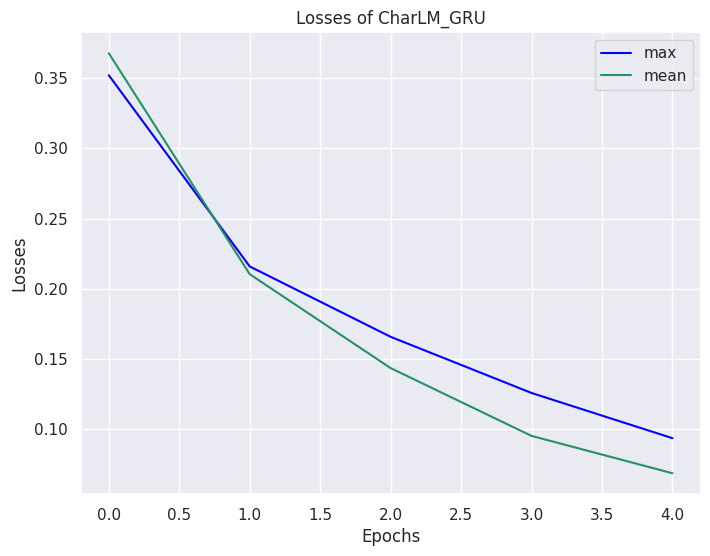

In [156]:
plt.figure(figsize=(8,6))
plt.plot(losses_gru_max, label="max", c="blue")
plt.plot(losses_gru_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM_GRU")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

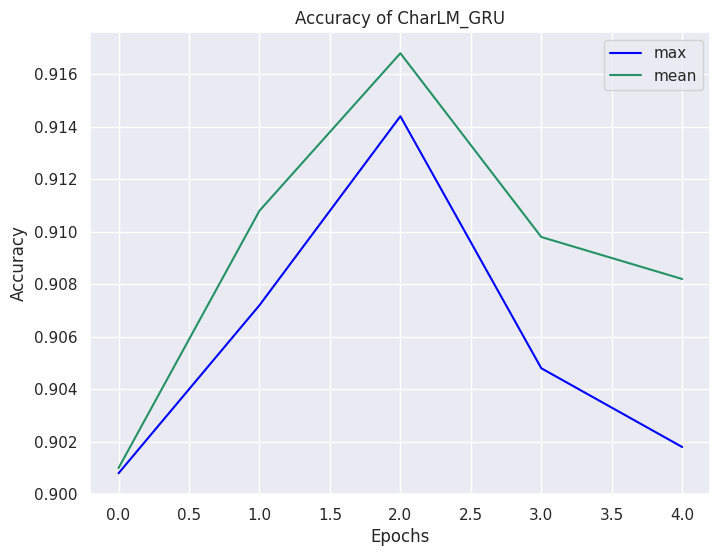

In [157]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_gru_max, label="max", c="blue")
plt.plot(accuracy_gru_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM_GRU")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

LSTM

In [80]:
class CharLM_LSTM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [130]:
model_lstm_max = CharLM_LSTM(hidden_dim=256, vocab_size=len(vocab), aggregation_type="max")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_lstm_max.parameters())

In [131]:
losses_lstm_max, accuracy_lstm_max = train(model_lstm_max, optimizer,
                                           criterion, train_dataloader,
                                           eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.3472844432691733, accuracy: 0.9047999978065491


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20684824012840788, accuracy: 0.9127999544143677


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.15055912562310694, accuracy: 0.9041999578475952


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.10635372584449748, accuracy: 0.9085999727249146


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.0744021343824764, accuracy: 0.902999997138977


In [132]:
print(f"Accuracy of model_lstm_max: {evaluate(model_lstm_max, eval_dataloader)}")

Accuracy of model_lstm_max: 0.902999997138977


In [143]:
model_lstm_mean = CharLM_LSTM(hidden_dim=256, vocab_size=len(vocab), aggregation_type="mean")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_lstm_mean.parameters())

In [144]:
losses_lstm_mean, accuracy_lstm_mean = train(model_lstm_mean, optimizer,
                                             criterion, train_dataloader,
                                             eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.36188549681405224, accuracy: 0.9019999504089355


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20648934326718252, accuracy: 0.9120000004768372


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.14067861326672138, accuracy: 0.9101999998092651


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.08614094242791956, accuracy: 0.914199948310852


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.05466382247855266, accuracy: 0.9052000045776367


In [145]:
print(f"Accuracy of model_lstm_mean: {evaluate(model_lstm_mean, eval_dataloader)}")

Accuracy of model_lstm_mean: 0.9052000045776367


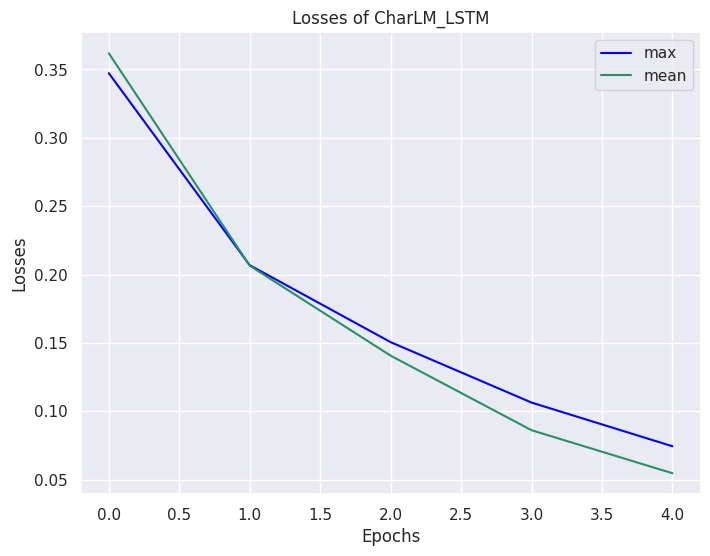

In [146]:
plt.figure(figsize=(8,6))
plt.plot(losses_lstm_max, label="max", c="blue")
plt.plot(losses_lstm_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM_LSTM")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

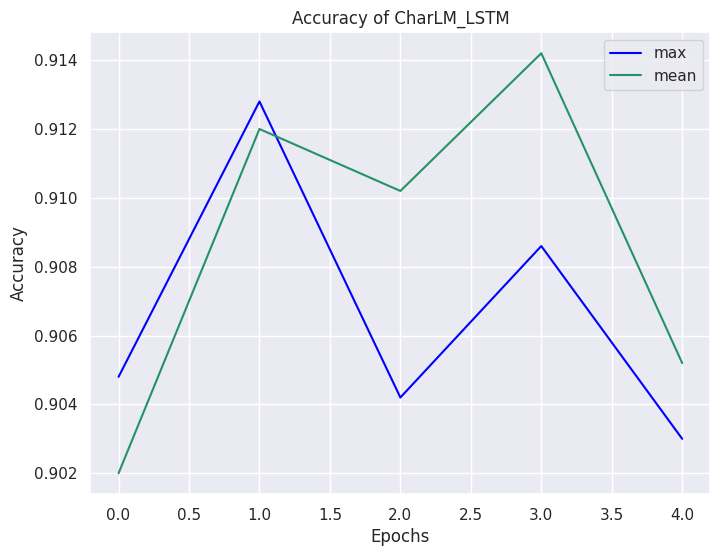

In [147]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_lstm_max, label="max", c="blue")
plt.plot(accuracy_lstm_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM_LSTM")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

### Третий эксперимент

Попробуем увеличить количество эпох и размер hidden_dim

Сначала попробуем n_epochs = 10

In [89]:
model_epochs10_max = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type="max")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_epochs10_max.parameters())

In [90]:
losses_epochs10_max, accuracy_epochs10_max = train(model_epochs10_max, optimizer,
                                                   criterion, train_dataloader,
                                                   eval_dataloader, 10)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.4093272961358229, accuracy: 0.8763999938964844


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.27859685804148515, accuracy: 0.8885999917984009


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2447695337176323, accuracy: 0.9019999504089355


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.22097402916749317, accuracy: 0.8953999876976013


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20274672551502784, accuracy: 0.9039999842643738


Training epoch 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.18511802173828085, accuracy: 0.9070000052452087


Training epoch 7:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1710936749515434, accuracy: 0.9035999774932861


Training epoch 8:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1600229698182394, accuracy: 0.8987999558448792


Training epoch 9:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.15025395608320832, accuracy: 0.8955999612808228


Training epoch 10:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1407228970532616, accuracy: 0.8955999612808228


In [91]:
print(f"Accuracy of model_epochs10_max: {evaluate(model_epochs10_max, eval_dataloader)}")

Accuracy of model_epochs10_max: 0.8955999612808228


In [92]:
model_epochs10_mean = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type="mean")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_epochs10_mean.parameters())

In [93]:
losses_epochs10_mean, accuracy_epochs10_mean = train(model_epochs10_mean, optimizer,
                                                     criterion, train_dataloader,
                                                     eval_dataloader, 10)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.43637317765653133, accuracy: 0.863599956035614


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2581958158090711, accuracy: 0.9109999537467957


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.21454772415608167, accuracy: 0.9061999917030334


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1837754339983066, accuracy: 0.8980000019073486


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1613836428123216, accuracy: 0.9088000059127808


Training epoch 6:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.14263537139482796, accuracy: 0.9065999984741211


Training epoch 7:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.12731099790738273, accuracy: 0.9052000045776367


Training epoch 8:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1155244982526948, accuracy: 0.9013999700546265


Training epoch 9:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.10777307572464148, accuracy: 0.901199996471405


Training epoch 10:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.09829360658489168, accuracy: 0.8971999883651733


In [94]:
print(f"Accuracy of model_epochs10_mean: {evaluate(model_epochs10_mean, eval_dataloader)}")

Accuracy of model_epochs10_mean: 0.8971999883651733


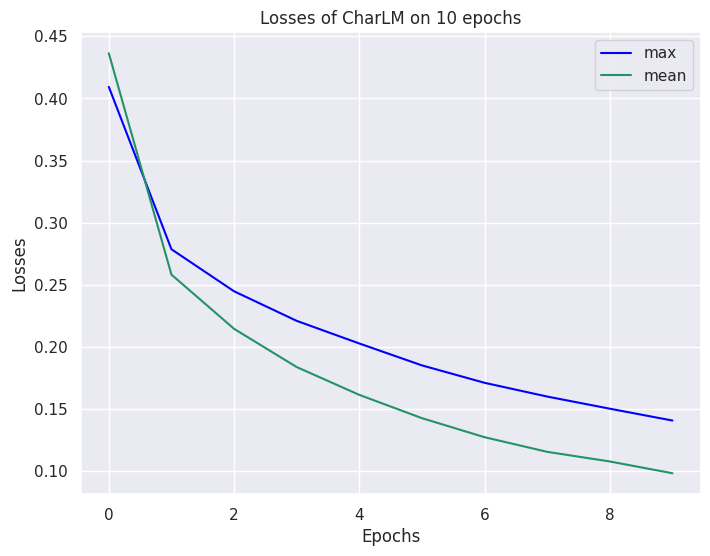

In [95]:
plt.figure(figsize=(8,6))
plt.plot(losses_epochs10_max, label="max", c="blue")
plt.plot(losses_epochs10_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM on 10 epochs")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

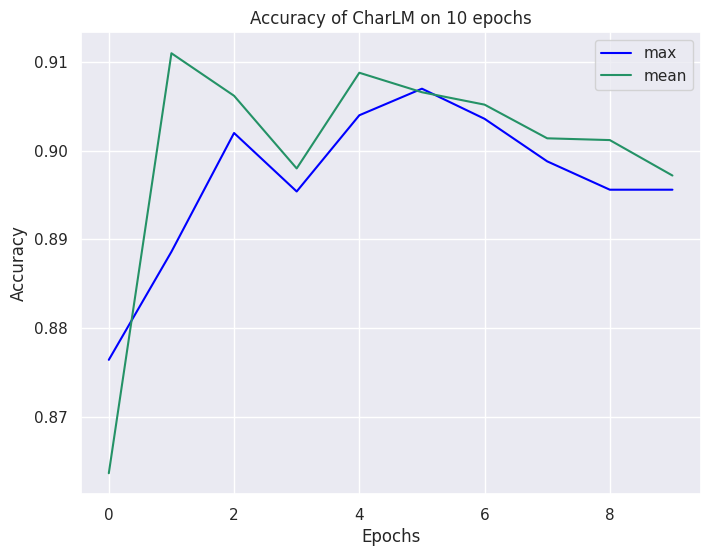

In [96]:
plt.figure(figsize=(8,6))
plt.plot(accuracy_epochs10_max, label="max", c="blue")
plt.plot(accuracy_epochs10_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM on 10 epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

Попробуем изменить hidden_dim на 512

In [97]:
model_dim512_max = CharLM(hidden_dim=512, vocab_size=len(vocab), aggregation_type="max")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_dim512_max.parameters())

In [98]:
losses_dim512_max, accuracy_dim512_max = train(model_dim512_max, optimizer,
                                               criterion, train_dataloader,
                                               eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.43225494511326157, accuracy: 0.8795999884605408


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.31950818130274616, accuracy: 0.8727999925613403


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.28689551732142765, accuracy: 0.8845999836921692


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.26356078550865253, accuracy: 0.9013999700546265


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.2537336146116257, accuracy: 0.9005999565124512


In [99]:
print(f"Accuracy of model_dim512_max: {evaluate(model_dim512_max, eval_dataloader)}")

Accuracy of model_dim512_max: 0.9005999565124512


In [100]:
model_dim512_mean = CharLM(hidden_dim=512, vocab_size=len(vocab), aggregation_type="mean")
criterion = nn.CrossEntropyLoss(ignore_index=word2ind["<pad>"])
optimizer = torch.optim.Adam(model_dim512_mean.parameters())

In [101]:
losses_dim512_mean, accuracy_dim512_mean = train(model_dim512_mean, optimizer,
                                                 criterion, train_dataloader,
                                                 eval_dataloader, 5)

Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.417682755463322, accuracy: 0.8873999714851379


Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.26501024132321277, accuracy: 0.899399995803833


Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.22574875639056166, accuracy: 0.9070000052452087


Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.20110247016151747, accuracy: 0.8987999558448792


Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

loss: 0.1856626342692723, accuracy: 0.9047999978065491


In [102]:
print(f"Accuracy of model_dim512_mean: {evaluate(model_dim512_mean, eval_dataloader)}")

Accuracy of model_dim512_mean: 0.9047999978065491


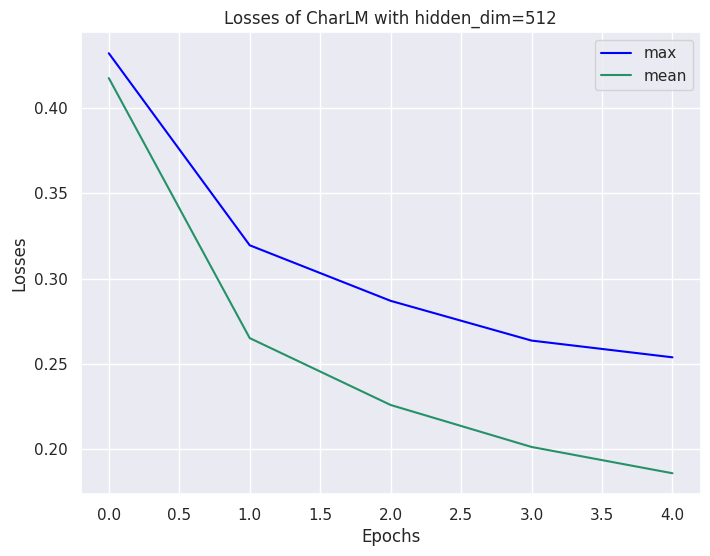

In [103]:
plt.figure(figsize=(8,6))
plt.plot(losses_dim512_max, label="max", c="blue")
plt.plot(losses_dim512_mean, label="mean")
plt.legend()
plt.title("Losses of CharLM with hidden_dim=512")
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.show()

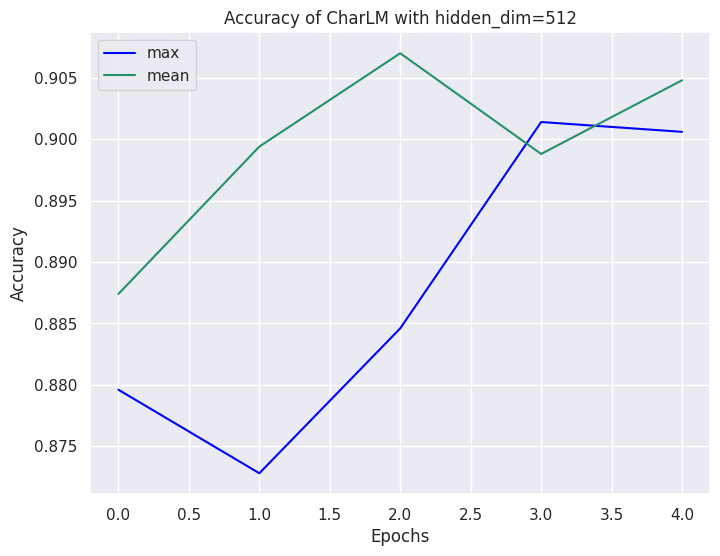

In [104]:
 plt.figure(figsize=(8,6))
plt.plot(accuracy_dim512_max, label="max", c="blue")
plt.plot(accuracy_dim512_mean, label="mean")
plt.legend()
plt.title("Accuracy of CharLM with hidden_dim=512")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

### Выбор лучшей модели

In [158]:
all_accuracies = {}
accuracy_values = [accuracy_base_max, accuracy_base_mean,
                  accuracy_rnn2_max, accuracy_rnn2_mean,
                  accuracy_rnn3_max, accuracy_rnn3_mean,
                  accuracy_gru_max, accuracy_gru_mean,
                  accuracy_lstm_max, accuracy_lstm_mean,
                  accuracy_epochs10_max, accuracy_epochs10_mean,
                  accuracy_dim512_max, accuracy_dim512_mean]

accuracy_names = ["accuracy_base_max", "accuracy_base_mean",
                    "accuracy_rnn2_max", "accuracy_rnn2_mean",
                    "accuracy_rnn3_max", "accuracy_rnn3_mean",
                    "accuracy_gru_max", "accuracy_gru_mean",
                    "accuracy_lstm_max", "accuracy_lstm_mean",
                    "accuracy_epochs10_max", "accuracy_epochs10_mean",
                    "accuracy_dim512_max", "accuracy_dim512_mean"]

for i, name in enumerate(accuracy_names):
    all_accuracies[name] = (max(accuracy_values[i]), accuracy_values[i].index(max(accuracy_values[i])))

for key, value in all_accuracies.items():
    print(key, value)

accuracy_base_max (0.9043999910354614, 4)
accuracy_base_mean (0.9106000065803528, 3)
accuracy_rnn2_max (0.9081999659538269, 3)
accuracy_rnn2_mean (0.9035999774932861, 4)
accuracy_rnn3_max (0.9073999524116516, 3)
accuracy_rnn3_mean (0.9049999713897705, 2)
accuracy_gru_max (0.9143999814987183, 2)
accuracy_gru_mean (0.9167999625205994, 2)
accuracy_lstm_max (0.9127999544143677, 1)
accuracy_lstm_mean (0.914199948310852, 3)
accuracy_epochs10_max (0.9070000052452087, 5)
accuracy_epochs10_mean (0.9109999537467957, 1)
accuracy_dim512_max (0.9013999700546265, 3)
accuracy_dim512_mean (0.9070000052452087, 2)


Лучший результат показала модель GRU_mean

Точность: 0.9168

### Вывод

Сильное улучшение от базовой модели получилось достичь только благодаря изменению архитектуры - с RNN на LSTM и GRU

У всех моделей Loss стабильно падал, но accuracy "скакал"

Лучший результат выдала модель с GRU, также хороший результат показала модель с LSTM